In [183]:
!pip install transformers

In [184]:
import tensorflow as tf
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import os
import shutil
import re
import matplotlib.pyplot as plt

In [195]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [196]:
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_151 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [197]:
# retrieve IMDB data from repo
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

In [198]:
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

['urls_unsup.txt', 'unsupBow.feat', 'urls_neg.txt', 'neg', 'labeledBow.feat', 'pos', 'urls_pos.txt']


In [199]:
# create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split.
# process the entire data in a single batch
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [200]:
# create a pandas dataframe from TensorFlow dataset object
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,Canadian director Vincenzo Natali took the art...,1
1,I gave this film 10 not because it is a superb...,1
2,I admit to being somewhat jaded about the movi...,1
3,"For a long time, 'The Menagerie' was my favori...",1
4,A truly frightening film. Feels as if it were ...,0


In [201]:
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,I can't believe that so much talent can be was...,0
1,This movie blows - let's get that straight rig...,0
2,"The saddest thing about this ""tribute"" is that...",0
3,I'm only rating this film as a 3 out of pity b...,0
4,Something surprised me about this movie - it w...,1


In [ ]:
#create sequences from our dataset.
InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)

InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)

In [202]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

In [203]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [204]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
   1250/Unknown - 1112s 879ms/step - loss: 0.3584 - accuracy: 0.8338WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
1250/1250 [==============================] - 1159s 916ms/step - loss: 0.3583 - accuracy: 0.8338 - val_loss: 0.3172 - val_accuracy: 0.8822
Epoch 2/2
1250/1250 [==============================] - 1140s 912ms/step - loss: 0.1015 - accuracy: 0.9659 - val_loss: 0.4265 - val_accuracy: 0.8878


In [205]:
model_fname = 'IMDB_BG_BERT'
my_wd = '/content/drive/MyDrive/Colab Notebooks/raw_data/'
# model.save(os.path.join(my_wd, model_fname))

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [206]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/raw_data/bostonglobe2014.csv',
                 encoding='ISO-8859-1', 
                 )
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)
df.head()

,ï»¿text
0,['The Boston Police Department has issued a co...
1,"['\n individuals who worked in finance, insura..."
2,"['Dr. Kenneth C. Edelin, whose historic 1975 m..."
3,['The first words in the Bible are âIn the b...
4,"['When they go up, they form the centerpiece o..."


In [207]:
raw_sentences = df.values[:, 0]
# raw_sentences[:10]


In [208]:
selected_sentences = []
target_words = ['black', 'haitian', 'jamaican', 'dominican']
for raw_sentence in raw_sentences:
  result = [word for word in target_words if(word in raw_sentence)]
  if (bool(result)):
    selected_sentences.append(raw_sentence)
print(len(selected_sentences))

558


In [209]:
pred_sentences = []
for selected_sentence in selected_sentences[:100]:
  processed_sentence = re.sub(r"[\[\]]", "", selected_sentence)
  pred_sentences.append(processed_sentence) 

In [210]:
len(pred_sentences)

100

In [211]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = new_model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()

ValueError: ignored

In [ ]:
predicted_setences = { 
    "Negative": 0,
    "Positive": 0,
  }
for i in range(len(pred_sentences)):
  output_label = labels[label[i]]
  predicted_setences[output_label] += 1

In [ ]:
def pre_process_text(file, lemma_file, token_file):

In [ ]:
predicted_setences

{'Negative': 3, 'Positive': 7}

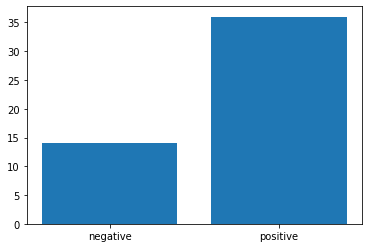

In [ ]:
plt.bar(['negative', 'positive'], [predicted_setences['Negative'], predicted_setences['Positive']])
plt.show()